

# Random Graphs: Erdős–Rényi

## Why Random Graphs?

[Recently](07-real-world.qmd), we measured several properties of real-world networks. Some of our measurements included the number of connected components, the proportion of possible triangles realized, and the mean length of paths between nodes. When interpreting these measurements, we face two important questions:

> 1. Is a given observation of an empirical network interesting or surprising in some way?
> 2. What properties of the graph would be sufficient to explain that observation?

For example, suppose that we measure the transitivity (proportion of realized triangles) in a graph and find a value of $0.4$. Is that interesting or surprising? If so, how would we explain it? For example, would the degree sequence alone be sufficient to explain this observation, or would we need to consider more detailed graph properties in order to explain it?

The way that we usually approach these questions is with *mathematical models of graphs*. We determine whether measurements are surprising by comparing to mathematical models. We can also design models that hold certain features fixed (like the degree sequence) in order to see whether those features are sufficient on their own to explain the value of other measurements (like transitivity). Because real data is usually messy and noisy, it's helpful for us to allow our mathematical models to be messy and noisy too! Our models are therefore random models of graphs, or just ***random graphs*** for short.

In addition to the role of random graphs in contextualizing and explaining network measurements, they are also very interesting mathematical objectis in their own right!
Indeed, there is an entire field of mathematics about the theory of random graphs.
Random graph models are also helpful for algorithms for network data analysis, including in both the design and analysis of these algorithms.



## The $G(n,p)$ Model (Erdős–Rényi)

The model of @erdHos1960evolution is the simplest and most fundamental model of a random graph. Our primary interest in the ER model is for mathematical insight and null modeling. The ER model is *mostly* understood in its major mathematical properties, and it's almost never used in statistical inference. [The ER model is, however, a building block of models that *are* used in statistical inference. The [stochastic blockmodel](https://en.wikipedia.org/wiki/Stochastic_block_model), for example, is often used for graph clustering and community detection. In its simplest form, it's a bunch of ER graphs glued together.]{.aside}

::: {.callout-note}
::: {#def-ER}

## Erdős–Rényi Random Graph

An *Erdős–Rényi random graph* with $n$ nodes and connection probability $p$, written $G(n,p)$, is a random graph constructed by placing an edge with probability $p$ between each pair of distinct nodes.

:::
:::

We can imagine visiting each possible pair of edges $(i,j)$ and flipping a coin with probability of heads $p$. If heads, we add $(i,j) \in E$; otherwise, we don't. Indeed, one (relatively inefficient) implementation of the $G(n,p)$ model works exactly like this. [The hidden code block prepares for our implementation of $G(n,p)$ by importing several libaries and setting plotting styles.]{.aside}

In [1]:
import networkx as nx
import numpy as np
from itertools import combinations
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(1234)

In [8]:
def gnp(n, p):
    G = nx.Graph()
    for i, j in combinations(range(n), 2):
      if np.random.random() < p:
        G.add_edge(i, j)
    return G

Having implemented this function, we can now generate a graph.

In [9]:
G = gnp(100, 0.03)

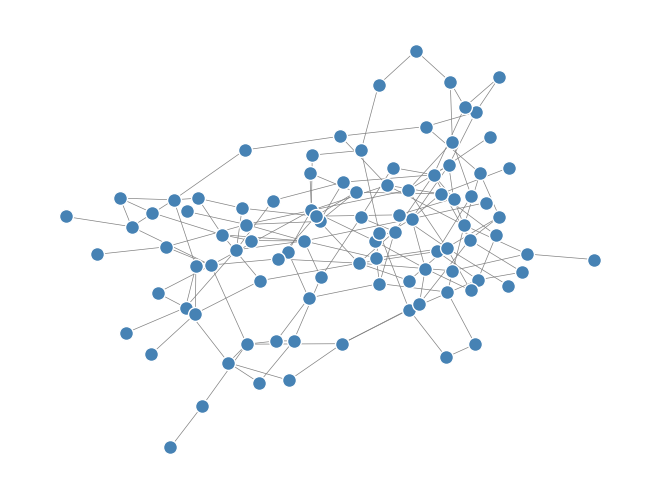

In [10]:
nx.draw(G,
        node_size = 100,
        edge_color = "gray",
        width = 0.5,
        edgecolors = "white",
        node_color = "steelblue")

This approach to generating $G(n,p)$ graphs by looping through all pairs of edges is not the most efficient possible; see @ramani2019coin for faster algorithms.

### Basic Properties

Let's now explore some of the fundamental mathematical properties of $G(n,p)$ graphs.

::: {.callout-caution}
**Exercise**: Let $i$ be a fixed node in a $G(n,p)$ graph, and let $K_i$ be its (random) degree. Show that $K_i$ has binomial distribution with success probability $p$ and $n-1$ trials.
:::

::: {.hide .solution}
A given node $u$ is connected to each of the other $n-1$ nodes (independently) with probability $p$. The probability of being connected to a particular set of $k$ nodes is

$$
\begin{align}
    \mathbb{P}[\text{connected to $k$ given nodes}] &= \mathbb{P}[\text{$k$ successes}]\mathbb{P}[\text{$n-1-k$ failures}] \\
    &= p^k (1-p)^{n-1-k} \,.
\end{align}
$$

Building on this, the probability of being connected to $k$ other nodes in any way is

$$
\begin{align}
    \mathbb{P}[\text{connected to $k$ nodes}] &= \left( \text{number of ways to choose $k$ nodes }\right) \mathbb{P}[\text{$k$ successes}]\mathbb{P}[\text{$n-1-k$ failures}] \\ \\
    &= {n-1 \choose k} p^k (1-p)^{n-1-k} \,.
\end{align}
$$

Indeed, this is exactly the binomial degree distribution, as required.
:::

::: {.callout-caution}
**Exercise**: Show that, for any node $i$,  $\mathbb{E}[K_i] = p(n-1)$.
:::

::: {.hide .solution}
Using our previous calculations, we know $\mathbb{E}[K_i] = \mathbb{E}[\frac{2m}{n}].$ However, $n$ is fixed for the $G(n,p)$ model, so we have $\mathbb{E}[K_i] = \frac{2}{n}\mathbb{E}[m],$ where $\mathbb{E}[m]$ is the expected number of edges. This quantity will be equal to the probability that an edge exists between a pair of nodes multiplied by the number of possible pairs, which is ${n \choose 2}p = \frac{n(n-1)}{2}p$. Thus $\mathbb{E}[K_i] = (n-1)p$, as required.
:::

### Clustering Coefficient of $G(n,p)$

Let's work an example of estimating a property of the $G(n,p)$ model.
We're going to estimate the transitivity, also called the *global clustering coefficient* of the $G(n,p)$ model.
Recall that the transitivity is defined as

$$
\begin{aligned}
    T = \frac{\text{number of triangles}}{\text{number of wedges}}\;.
\end{aligned}
$$

Here, a wedge on node $i$ is a *possible triangle*: two edges $(i,j)$ and $(i,k)$. The addition of the edge $(j,k)$ would complete the triangle.

Let's estimate the value of $T$ for the $G(n,p)$ model.
Analyzing ratios using probability theory can get tricky, but we can get a pretty reliable picture of things by computing the expectations of the numerator and denominator separately.

How many triangles are there? We can choose a "base" node $i$ in $n$ ways and then choose a pair of additional nodes $j$ and $k$ in $\binom{n-1}{2}$ ways. The probability that all three edges exist is $p^3$. So, in expectation, there are $n\binom{n-1}{2}p^3$ triangles in the graph.

On the other hand, how many wedges are there? We can again choose the base node $i$ and the two additional nodes in a total of $n\binom{n-1}{2}$ ways. A wedge (potential triangle) exists if the edges $(i,j)$ and $(i,k)$ are present, which occurs with probability $p^2$.

The ratio between these two expectations is $p$. Indeed, it's possible to prove using *concentration inequalities* that, in this case, the expected transitivity is indeed very close to this ratio of expectations.

Let's compute the transitivity of a $G(n,p)$ graph with NetworkX. We'll use a larger graph size for this experiment:

In [44]:
G = nx.fast_gnp_random_graph(1000, 0.03)
nx.transitivity(G) # Expectation of transitivity is p

0.03002153072909753

The observed value of the clustering coefficient is  close to the prediction of our approximate calculation.


## Sparse $G(n,p)$

Recall that it is possible to define sparsity more explicitly when we have a theoretical model (where it makes sense to take limits). Indeed, the *sparse* Erdős–Rényi model is very useful. Intuitively, the idea of sparsity is that there are not very many edges in comparison to the number of nodes. [It is also possible to consider other functional forms for $p$ which are also often called "sparse" and lead to interesting behavior; for example $p = \frac{c \log n}{n}$]{.aside}

::: {.callout-note}
::: {#def-sparse-ER}
We say that a $G(n,p)$ graph is **sparse** when $p = c/(n-1)$ for some constant $c$.
:::
:::

A consequence of sparsity is that $\mathbb{E}[K_i] = c$; i.e. the expected degree of a node in sparse $G(n,p)$ is constant. When studying sparse $G(n,p)$, we are almost always interested in reasoning in the limit $n\rightarrow \infty$.

### Degrees

It is possible to show that, when $p = c/(n-1)$, the degree of a node in sparse $G(n,p)$ converges (in distribution) to a Poisson random variable with mean $c$. For this reason, the $G(n,p)$ is also sometimes called the *Poisson random graph*. [A Poisson random variable $K$ with mean $\lambda$ has probability mass function $p_K(k) = \frac{\lambda^k e^{-k}}{k!}.]{.aside}


### Clustering

What does this imply for our estimation of the global clustering coefficient from before? Well, we expect the global clustering coefficient to be *about* $p$, and if $p = c/(n-1)$, then $p \rightarrow 0$ as $n \to \infty$ for sparse $G(n,p)$. We've given a heuristic argument showing that $T \approx p$, and so our analysis predicts:

[The need to move beyond the ER model to develop sparse graphs with clustering coefficients was part of the motivation of @watts1998collective, a famous paper that introduced the "small world model."]{.aside}

> Sparse Erdős–Rényi graphs have vanishing clustering coefficients.

@fig-clustering-decay shows how the global clustering coefficient of a sparse Erdős–Rényi random graph decays as we increase $n$.

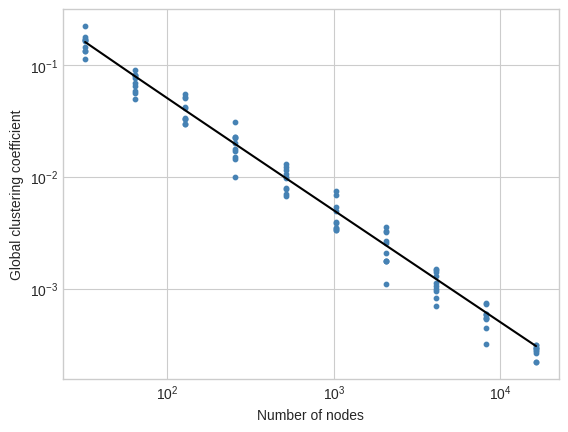

In [45]:

c = 5
N = np.repeat(2**np.arange(5, 15), 10)

def global_clustering(n, c):
    G = nx.fast_gnp_random_graph(n, c/(n-1))
    return nx.transitivity(G)

T = [global_clustering(n, c) for n in N]

fig, ax = plt.subplots(1)

theory = ax.plot(N, c/(N-1), color = "black", label = "Estimate")

exp = ax.scatter(N, T, label = "Experiments", color = "steelblue", s = 10)
semil = ax.loglog()
labels = ax.set(xlabel = "Number of nodes",
       ylabel = "Global clustering coefficient")
plt.show()

Although the estimate that the global clustering coefficient should be equal to $p$ was somewhat informal, experimentally it works quite well.

### Cycles and Local Tree-Likeness

Recall the following definition:

::: {.callout-note}
::: {#def-cycle}
A **cycle** is a walk that does not repeat edges and ends at the same node that it begins.
:::
:::

A triangle is an example of a cycle of length $3$. Our argument about the graph transitivity shows that triangles are *rare* in sparse $G(n,p)$ graphs: if I look at any given wedge, the probability that the wedge is completed to form a triangle shrinks to zero with rate $n^{-1}$. In fact, it is true more generally that cycles of any length are rare in sparse $G(n,p)$ graphs.

::: {.callout-tip}
::: {#thm-rare-cycles}
In the sparse $G(n,p)$ model, for any length $k$, the probability that there exists a cycle of length $k$ attached to node $i$ shrinks to 0 as $n \rightarrow \infty$.
:::
:::


Graphs in which cycles are rare are often called *locally tree-like*. A tree is a graph without cycles; if cycles are very rare, then we can often use techniques algorithms that are normally guaranteed to only work on trees without running into (too much) trouble.

### Path Lengths

How far apart are two nodes in $G(n,p)$? Again, exactly computing the length of geodesic paths involves some challenging mathematical detail. [See @riordan2010diameter and references therein.]{.aside} However, we can get a big-picture view of the situation by asking a slightly different question:

> Given two nodes $i$ and $j$, what is the expected number of paths of length $k$ between them?

Let $R(k)$ denote the number of $k$-paths between $i$ and $j$. Let $r(k) = \mathbb{E}[R(k)]$. Let's estimate $r(k)$.

First, we know that $r(1) = p$. For higher values of $k$, we'll use the following idea: in order for there to be a path of length $k$ from $i$ to $j$, there must be a node $\ell$ such that:

- There exists a path from $i$ to $\ell$ of length $k-1$. In expectation, there are $r(k-1)$ of these.
- There exists a path from $\ell$ to $j$ of length $1$. This happens with probability $p$.

There are $n-2$ possibilities for $\ell$ (excluding $i$ and $j$), and so we obtain the approximate relation

$$
r(k) \approx (n-2)r(k-1)p\;.
$$


:::{.callout-warning}
Why is this an approximation? Well, some of the paths between $i$ and $\ell$ that are counted in $r(k-1)$ could actually include the edge $(j, \ell)$ *already*. An example is $(i,j), (j,\ell)$. In this case, the presence of edge $(j,\ell)$ is not independent of the presence of the path between $i$ and $\ell$. The derivation above implicitly treats these two events as independent. Again, because *cycles are rare in large, sparse ER*, this effect is small when $k$ is small.
:::

Proceeding inductively and approximating $n-2 \approx n-1$ for $n$ large, we have the relation

$$
r(k) \approx (n-1)^{k-1}p^{k-1}r(1) = c^{k-1}p
$$ {#eq-path-expectation}

in the sparse ER model.

Using this result, let's ask a new question:

> What path length $k$ do I need to allow to be confident that there's a path of length $k$ between nodes $i$ and $j$?

Well, suppose we want there to be $q$ paths. Then, we can solve $q = c^{k-1}p$ for $k$, which gives us:

$$
\begin{aligned}
q &= c^{k-1}p \\
\log q &= (k-1)\log c + \log p \\
\log q &= (k-1)\log c + \log c - \log n \\
\frac{\log q + \log n}{\log c} &= k
\end{aligned}
$$


In [ ]:
import math
num_paths_desired_1 = 1
num_paths_desired_2 = 1000000

def path_length(n, c, num_paths_desired):
    return float(np.round((np.log(num_paths_desired) + np.log(n))/np.log(c), 1))

k_1 = path_length(int(8e9), 1000, num_paths_desired_1)
k_2 = path_length(int(8e9), 1000, num_paths_desired_2)

Here, we've also approximated $\log (n-1) \approx \log n$ for $n$ large. This result tells us that *distances between nodes grow very slowly in $G(n,p)$*, roughly at the rate $\log n$. This is *very* slow growth. For example, supposing that I want there to be at least one path in expectation ($q = 1$), I need to allow $k = \frac{\log n}{\log c}$. The population of the world is about $8\times 10^9$, and Newman estimates that an average individual knows around 1,000 other people; that is, $c = 10^3$ in the world social network. The resulting value of $k$ here is around `{python} k_1`. If on the other hand we wanted to be quite confident that a path exists, we might instead wish to require `{python} num_paths_desired_2` paths, leading to a required path length of roughly `{python} k_2`.

In other words, this calculation suggests that, if the world were an ER network, it would be very likely for any two given individuals to be connected by paths of length no longer than `{python} math.ceil(k_2)`. [Results in this spirit have been born out by experiments in the social sciences, such as the "small world" experiment of @milgram1967small.]{.aside}

More formal calculations regarding the diameter (length of longest shortest path) of the ER graph confirm that the diameter of the ER graph grows slowly as a function of $n$.


### A Caveat

If you spend some time looking at @eq-path-expectation, you might find yourself wondering:

> Hey, what happens if $c \leq 1$?  

Indeed, something *very* interesting happens here.
Let's assume $c < 1$ (i.e. we're ignoring the case $c = 1$), and estimate the expected number of paths between $i$ and $j$ of *any* length. Using @eq-path-expectation, we get

$$
\mathbb{E}\left[\sum_{k = 1}^{\infty} R(k)\right] = \sum_{k = 1}^\infty c^{k-1}p = \sum_{k = 0}^\infty c^kp = \frac{p}{1-c}\;.
$$

If we now use Markov's inequality, [Markov's inequality states that $\mathbb{P}(X \geq a) \leq \frac{\mathbb{E}(X)}{a}$.]{.aside} we find that the probability that there is a path of *any* length between nodes $i$ and $j$ is no larger than $\frac{p}{1-c}.$ In the sparse regime, we can substitute $p = \frac{c}{n-1}$ to see that  

$$
\frac{c}{(1-c)(n-1)}\rightarrow 0 \text{ as } n \to \infty\;.
$$

So, this suggests that, if $c < 1$, any two nodes are likely to be disconnected! On the other hand, if $c > 1$, we've argued that we can make $k$ large enough to have high probability of a path of length $k$ between those nodes.

So, what's special about $c = 1$? This question brings us to one of the first and most beautiful results in the theory of random graphs. To get there, let's study in a bit more detail the sizes of the *connected components* of the ER graph.

## Component Sizes and the Branching Process Approximation

We're now going to ask ourselves about the size of a "typical" component in the Erdős–Rényi model. In particular, we're going to be interested in whether there exists a component that fills up "most" of the graph, or whether components tend to be vanishingly small in relation to the overall graph size.

Our first tool for thinking about this question is the *branching process approximation.* Informally, a branching process is a process of *random generational growth*. We'll get to a formal mathematical definition in a moment, but the easiest way to get insight is to look at a diagram:


::: {#fig-branching}

<iframe width="560" height="315" src="http://1.bp.blogspot.com/-Y59SK92Nd0c/VIoqelzfc8I/AAAAAAAAAdA/XAQB5yDStUc/s1600/eg1.PNG"></iframe>

[Image source](http://mytechroad.com/markov-chain-branching-process/).
:::

We start with a single entity, $X_0$. Then, $X_0$ has a random number of "offspring": $X_1$ in total. Then, each of those $X_1$ offspring has some offspring of their own; the total number of these offspring is $X_2$. The process continues infinitely, although there is always a chance that at some point no more offspring are produced. In this case, we often say that the process "dies out."  


::: {.column-margin}
Some of this exposition in this section draws on [these notes](https://www.stat.berkeley.edu/users/aldous/Networks/lec2.pdf) by David Aldous.
:::


::: {.callout-note}
::: {#def-branching-process}

##  Branching Process

Let $p$ be a probability distribution on $\mathbb{Z}$, called the **offspring distribution**.  

A **branching process** with distribution $p$ is a sequence of random variables $X_0, X_1,,X_2\ldots$ such that $X_0 = 1$ and, for $t \geq 1$,  

$$
X_t = \sum_{i = 1}^{X_{t-1}} Y_i\;,
$$

where each $Y_i$ is distributed i.i.d. according to $p$.
:::
:::

::: {.column-margin}
Technically, this is a *Galton-Watson* branching process, named after the two authors who first proposed it [@watson1875probability]. <br> <br> **History note**: Galton, one of the founders of modern statistics, was a eugenicist. The cited paper is explicit about its eugenicist motivation: the guiding question was about whether certain family names associated with well-to-do aristocrats were giving way to less elite surnames.
:::

### Application to Erdős–Rényi

Branching processes create *trees* -- graphs without cycles. The reason that branching processes are helpful when thinking about Erdős–Rényi models is that *cycles are rare in Erdős–Rényi random graphs*. So, if we can understand the behavior of branching processes, then we can learn something about the Erdős–Rényi random graph as well.

Here's the particular form of the branching process approximation that we will use:


:::{.callout-note}
:::{#def-branching-approx}

## Branching Process Approximation for ER Component Sizes

Sample a single node $j$ at random from a large, sparse ER graph  with mean degree $c$, and let $S$ be the size (number of nodes) of the component in which $j$ lies. Note that $S$ is random: it depends both on $j$ and on the realization of the ER graph.

Then, $S$ is distributed approximately as $T$, where $T = \sum_{i = 0}^{\infty}X_t$ is the total number of offspring in a GW branching process with offspring distribution $\text{Poisson}(c)$.
:::
:::

The idea behind this approximation is:

- We start at $j$, whose number of neighbors $\sim \text{Poisson}(c)$.
- Each of these neighbors has a number of new neighbors $\sim \text{Poisson}(c)$, and so on.
- We keep visiting new neighbors until we run out, and add up the number of neighbors we've visited to obtain $S$.  
- Since *cycles are rare in ER*, we are unlikely to double-count any nodes (doing so would create a cycle), and so this whole process *also* approximately describes $T$ in a branching process with a $\text{Poisson}(c)$ offpsring distribution.

<!-- :::{.callout-important}
**Exercise**: In the second generation, we get to a new node by following an edge. For that reason, shouldn't the number of *new* edges be $\text{Poisson}(c-1)$ rather than $\text{Poisson}(c-1)$? Why or why not?
::: -->

### The Subcritical Case

The mean of a $\text{Poisson}(c)$ random variable is again $c$. This implies that $X_t$, the number of offspring in generation $t$, satisfies $\mathbb{E}[X_t] = c^{t}$. It follows that, when $c < 1$, $\mathbb{E}[T] = \frac{1}{1-c}$.

Now using Markov's inequality, we obtain the following results:

::: {.callout-tip}

In a $\text{Poisson}(c)$ branching process with $c < 1$,
$$
\begin{aligned}
    \mathbb{P}(X_t > 0) = \mathbb{P}(X_t \geq 0) \leq \frac{\mathbb{E}[X_t]}{1} = c^t\;.
\end{aligned}
$$
:::

So, the probability that the branching process hasn't yet "died out" decays exponentially with timestep $t$. In other words, the branching process becomes very likely to die out very quickly. What about the total number of nodes produced in the branching process? Again using Markov's inequality, we find that

::: {.callout-tip}

In a $\text{Poisson}(c)$ branching process with $c < 1$,
$$\mathbb{P}(T \geq a) \leq \frac{\mathbb{E}[T]}{a} = \frac{1}{a}\frac{1}{1-c}$$
:::

In particular, for $a$ very large, we are guaranteed that $\mathbb{P}(T > a)$ is very small.

Summing up, when $c < 1$, the GW branching process dies out quickly and contains a relatively small number of nodes: $\frac{1}{1-c}$ in expectation. [In this setting, the branching process is called *subcritical*.]{.aside}

#### Back to ER

If we now translate back to the Erdős–Rényi random graph, the branching process approximation now suggests the following heuristic:

::: {.callout-note}
**Heuristic**: In a sparse ER random graph with mean $c < 1$, the expected size of a component containing a randomly selected node is roughly $\frac{1}{1-c}$.

In particular, since this quantity is independent of $n$, we find that the *fraction* of the graph occupied by this component is $\frac{1}{n}\frac{1}{1-c}$ and therefore vanishes as $n\rightarrow \infty$.

We can also turn this into a statement about probabilities: Markov's inequality implies that, if $S$ is the size of a component containing a randomly selected node,

$$
\mathbb{P}(S/n > a) \rightarrow 0
$$

for any constant $a > 0$. In other words, for large $n$, the largest component is always vanishingly small in relation to the graph as a whole.
:::

Let's check this experimentally. The following code block computes the size of the component in an ER graph containing a random node, and averages the result across many realizations. The experimental result is quite close to the theoretical prediction.

In [ ]:
import networkx as nx
import numpy as np

def component_size_of_node(n, c):
    G = nx.fast_gnp_random_graph(n, c/(n-1))
    return len(nx.node_connected_component(G, 1))

c = 0.8
sizes = [component_size_of_node(5000, c) for i in range(1000)]

out = f"""
Average over experiments is {np.mean(sizes):.2f}.\n
Theoretical expectation is {1/(1-c):.2f}.
"""

print(out)

Note that the expected (and realized) component size is very small, even though the graph contains 5,000 nodes!

For this reason, we say that subcritical ER contains only *small* connected components, in the sense that each component contains approximately 0\% of the graph as $n$ grows large.

This explains our result from earlier about path lengths. The probability that any two nodes have a path between them is the same as the probability that they are *on the same connected component*. But if every connected component is small, then the probability that two nodes occupy the same one is vanishes.

### The Giant Component

::: {.callout-note}
::: {#def-giant-component}

## Giant Component

We say that $G(n,p)$ has a **giant component** if
$$
\mathbb{P}(S/n > a) \rightarrow b
$$
for some constant $b > 0$.

Intuitively, this means that there is a possibility of a connected component that takes up a nonzero fraction $b$ of the graph.
:::
:::

So far, we've argued using the branching process approximation that there is no giant component in the Erdős–Rényi model with $c < 1$. The theory of branching processes also suggests to us that there *could* be a giant component when $c > 1$.

[The proof of this fact is usually done in terms of *generating functions* and is beyond our scope, but you can [check Wikipedia](https://en.wikipedia.org/wiki/Branching_process#Extinction_problem_for_a_Galton_Watson_process) for an outline.]{.aside}

::: {.callout-warning}
**Fact**: when $c > 1$, there is a nonzero probability that the $\text{Poisson}(c)$ branching process continues forever; that is, never goes extinct.
:::

Using our correspondence between components of the ER model and branching processes, this suggests that, if we pick a random node, the component it is in has the potential to be very large. In fact (and this requires some advanced probability to prove formally), when $c > 1$, there *is* a giant component. This is our first example of a phase transition.
[It is also possible to prove that, with high probability, there is only one giant component; Newman does this in 11.5.1.]{.aside}

::: {.callout-note}
::: {#def-giant-component}

## Phase Transition

A **phase transition** is a qualitative change in response to a small variation in a quantitative parameter.
:::
:::

Examples of phase transitions include freezing, in which a liquid undergoes a qualitative change into a solid in response to a small variation in temperature.

@fig-giant-component-illustration shows  two sparse ER random graphs on either side of the $c = 1$ transition. We observe an apparent change in qualitative behavior between the two cases.

In [ ]:

import networkx as nx
from matplotlib import pyplot as plt

fig, axarr = plt.subplots(1, 2, figsize = (6, 3))

n = 500
c = [0.7, 1.3]

for i in range(2):
    G = nx.fast_gnp_random_graph(n, c[i]/(n-1))
    nx.draw(G, ax = axarr[i], node_size = 1)
    axarr[i].set(title = f"c = {c[i]}")

### Size of the Giant Component {#sec-component}

Perhaps surprisingly, while it's difficult to prove that there is a giant component, it's not hard at all to estimate its size.
[This argument is reproduced from Newman, pages 349-350]{.aside}

Let $S$ be the size of the giant component in an Erdős–Rényi random graph, assuming there is one. Then, $s = S/n$ is the probability that a randomly selected node is in the giant component. Let $u = 1 - s$ be the probability that a given node is *not* in the giant component.

Let's take a random node $i$, and ask it the probability that it's in the giant component. Well, one answer to that question is just "$u$." On the other hand, we can *also* answer that question by looking at $i$'s neighbors. If $i$ is not in the giant component, then it can't be connected to any node that is in the giant component. So, for each other node $j\neq i$, it must be the case that either:

1. $i$ is not connected to $j$. This happens with probability $1-p$.
2. $i$ is connected to $j$, but $j$ is not in the giant component either. $i$ is connected to $j$ with probability $p$, and $j$ is not in the giant component with probability $u$.

There are $n-1$ nodes other than $i$, and so the probability that $i$ is not connected to any other node in the giant component is $(1 - p + pu)^{n-1}$. We therefore have the equation

$$
u = (1 - p + pu)^{n-1}\;.
$$

Let's take the righthand side and use $p = c/(n-1)$:
$$
\begin{aligned}
    u &= (1 - p(1-u))^{n-1} \\
      &= \left(1 - \frac{c(1-u)}{n-1}\right)^{n-1}\;.
\end{aligned}
$$
This is a good time to go back to precalculus and remember the limit definition of the function $e^x$:
$$
e^x = \lim_{n \rightarrow \infty}\left(1 + \frac{x}{n}\right)^{n}\;.
$$
Since we are allowing $n$ to grow large in our application, we approximate

$$
u \approx e^{-c(1-u)}\;.
$$
So, now we have a description of the fraction of nodes that *aren't* in the giant component. We can get a description of how many nodes *are* in the giant component by substituting $s = 1-u$, after which we get the equation we're really after:
$$
s = 1- e^{-cs}
$${#eq-giant-component-size}

This equation doesn't have a closed-form solution for $s$, but we can still plot it and compare the result to simulations (@fig-giant-component). Not bad!

In [ ]:

import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

# experiment: compute the size of the largest connected
# component as a function of graph size for a range of mean degrees.

def largest_component(n, p):
    G = nx.fast_gnp_random_graph(n, p)
    S = max(nx.connected_components(G), key=len)
    return len(S) / n

n = 50000
C = np.repeat(np.linspace(0.5, 1.5, 11), 10)
U = np.array([largest_component(n, c/(n-1)) for c in C])

# theory: prediction based on Newman 11.16

S = np.linspace(-.001, .6, 101)
C_theory = -np.log(1-S)/S

# plot the results to compare

plt.plot(C_theory,
         S,
         color = "black",
         label = "Theoretical prediction",
         zorder = -1,
         linestyle = "--")

plt.scatter(C,
            U,
            label = "Experiment",
            facecolor = "steelblue",
            color = "white",
            alpha = 0.8,
            s = 150)

plt.gca().set(xlabel = "Mean degree",
              ylabel = "Proportion of graph in largest component")

plt.legend()

## Limitations of $G(n,p)$

The Erdős–Rényi model $G(n,p)$ is a hugely important object in random graph theory, and many mathematicians have devoted their careers to studying it. Many of its properties are tractable using tools from probability theory, and it even reproduces some interesting realistic behaviors, such as short path lengths and the existence of a giant component.
However, $G(n,p)$ also has severe limitations as a modeling framework. Since every degree has an approximate Poisson distribution with the same degree, the overall degree distribution is itself Poisson.
Many graphs have distinctly non-Poisson degree distributions, and $G(n,p)$ cannot produce that feature.
The scarcity of cycles, especially triangles, in $G(n,p)$ is also unlike many empirical networks.
$G(n,p)$ also can't reproduce networks with any kind of modular or community structure.

$G(n,p)$ is an extremely rich object of mathematical study and an important first model in the study of random graphs. That said, we'll now move on to models that are more able to reproduce some of the features we observe in empirical networks.

## References
